In [4]:
#!pip install yfinance
import yfinance as yf
from sklearn import preprocessing
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import SimpleRNN, LSTM, GRU, Dense
from matplotlib import pyplot as plt
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

In [5]:
stock_data = yf.Ticker('^KS11')
df = stock_data.history(start='2010-01-01',auto_adjust=False,actions=False)
df = df.dropna(axis=0)
df = df.drop(['Close'],axis=1)

In [8]:
print(df.shape)
print(df.head())

(2885, 5)
                   Open         High          Low    Adj Close  Volume
Date                                                                  
2010-01-04  1681.709961  1696.140015  1681.709961  1696.140015  296500
2010-01-05  1701.619995  1702.390015  1686.449951  1690.619995  408900
2010-01-06  1697.880005  1706.890015  1696.099976  1705.319946  426000
2010-01-07  1702.920044  1707.900024  1683.449951  1683.449951  462400
2010-01-08  1694.060059  1695.260010  1668.839966  1695.260010  380000


In [9]:
df_normaliser = preprocessing.MinMaxScaler()
df_normalised = df_normaliser.fit_transform(df)

history_points = 30 #예측하는데 사용하는 데이터 개수
x_normalised = np.array([df_normalised[i : i + history_points].copy() for i in range(len(df_normalised) - history_points)])
y_normalised = np.array([df_normalised[i + history_points : i + history_points + 1 , 3].copy() for i in range(len(df_normalised) - history_points)])
y = np.array([df.iloc[i + history_points : i + history_points + 1]['Adj Close'].values.copy() for i in range(len(df) - history_points)])

y_normaliser = preprocessing.MinMaxScaler()
y_normaliser.fit(y)

MinMaxScaler()

In [10]:
n = int(x_normalised.shape[0] * 0.8) # Train : Test = 8 : 2
x_train = x_normalised[:n]
y_train = y_normalised[:n]
x_test = x_normalised[n:]
y_test = y_normalised[n:]
unscaled_y_test = y[n:]

In [11]:
layer_num = 20
optimizer = 'adam'
batch_size = 10
epoch = 100

model = Sequential()
model.add(SimpleRNN(layer_num, return_sequences=True, input_shape=(history_points, len(x_train[0][0]))))
model.add(SimpleRNN(layer_num))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=optimizer)
model.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=epoch, shuffle=True, validation_split=0.1)

Epoch 1/100
206/206 [==============================] - 2s 7ms/step - loss: 7.0031e-04 - val_loss: 2.5387e-04
Epoch 2/100
206/206 [==============================] - 1s 6ms/step - loss: 2.2096e-04 - val_loss: 2.0970e-04
Epoch 3/100
206/206 [==============================] - 1s 6ms/step - loss: 2.1612e-04 - val_loss: 1.6406e-04
Epoch 4/100
206/206 [==============================] - 1s 6ms/step - loss: 1.8638e-04 - val_loss: 1.5152e-04
Epoch 5/100
206/206 [==============================] - 1s 6ms/step - loss: 1.9397e-04 - val_loss: 4.4278e-04
Epoch 6/100
206/206 [==============================] - 1s 6ms/step - loss: 1.5948e-04 - val_loss: 1.9328e-04
Epoch 7/100
206/206 [==============================] - 1s 6ms/step - loss: 1.6522e-04 - val_loss: 3.6460e-04
Epoch 8/100
206/206 [==============================] - 1s 6ms/step - loss: 1.7688e-04 - val_loss: 1.3487e-04
Epoch 9/100
206/206 [==============================] - 1s 6ms/step - loss: 1.5479e-04 - val_loss: 1.4169e-04
Epoch 10/100
206/20

206/206 [==============================] - 1s 6ms/step - loss: 1.1193e-04 - val_loss: 1.1674e-04
Epoch 76/100
206/206 [==============================] - 1s 6ms/step - loss: 1.1851e-04 - val_loss: 1.1165e-04
Epoch 77/100
206/206 [==============================] - 1s 6ms/step - loss: 1.1465e-04 - val_loss: 1.1557e-04
Epoch 78/100
206/206 [==============================] - 1s 6ms/step - loss: 1.1171e-04 - val_loss: 2.6709e-04
Epoch 79/100
206/206 [==============================] - 1s 6ms/step - loss: 1.1405e-04 - val_loss: 1.0955e-04
Epoch 80/100
206/206 [==============================] - 1s 6ms/step - loss: 1.1868e-04 - val_loss: 1.1270e-04
Epoch 81/100
206/206 [==============================] - 1s 6ms/step - loss: 1.1722e-04 - val_loss: 1.1355e-04
Epoch 82/100
206/206 [==============================] - 1s 6ms/step - loss: 1.1185e-04 - val_loss: 1.1139e-04
Epoch 83/100
206/206 [==============================] - 1s 6ms/step - loss: 1.0892e-04 - val_loss: 1.1475e-04
Epoch 84/100
206/206 [=

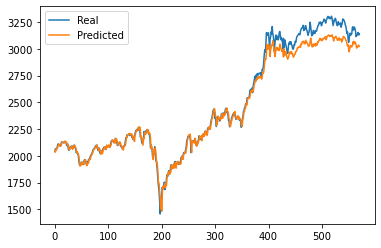

MSE : 5860.6718314006375 , Scaled MSE : 317.2097404578426


In [12]:
y_test_predicted = model.predict(x_test)
y_test_predicted = y_normaliser.inverse_transform(y_test_predicted)

real_mse = np.mean(np.square(unscaled_y_test - y_test_predicted))
scaled_mse = real_mse / (np.max(unscaled_y_test) - np.min(unscaled_y_test)) * 100

real = plt.plot(unscaled_y_test, label='real')
pred = plt.plot(y_test_predicted, label='predicted')
plt.legend(['Real', 'Predicted'])
plt.show()
print('MSE :', real_mse, ', Scaled MSE :', scaled_mse)